## Prereqs and Helper Functions

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

In [2]:
def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path
    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path

In [3]:
class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

In [4]:
class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]

In [5]:
sys.meta_path.append(NotebookFinder())

In [6]:
#Review of overall data quality
def nullcounts(ser):
    return ser.isnull().sum()

def detail_describe(frame, func=['count', nullcounts, 'mean', 'std', 'min', 'median', 'max'],
                    numeric_only=False, **kwargs):
    return frame.agg(func, **kwargs)

## Import Data Prep 

In [7]:
import lab1_final_data

importing Jupyter notebook from lab1_final_data.ipynb


## Verify Data

In [8]:
lab1_final_data.kick_imputed_scaled

,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Trim,SubModel,Color,Transmission,WheelTypeID,WheelType,VehOdo,Nationality,Size,TopThreeAmericanName,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionRetailAveragePrice,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost,Mileage,Luxury,Axle,state,zip,Cylinder,model_short
0,0,1260144000,ADESA,2006,3,MAZDA,i,4D SEDAN I,RED,AUTO,1,Alloy,0.759487,OTHER ASIAN,MEDIUM,OTHER,0.228291,0.297748,21973,33619,FL,0.156132,0,0.092524,HIGH,0,Unknown,FL,33619.0,Unknown,MAZDA3
1,0,1260144000,ADESA,2004,5,DODGE,ST,QUAD CAB 4.7L SLT,WHITE,AUTO,1,Alloy,0.800491,AMERICAN,LARGE TRUCK,CHRYSLER,0.191871,0.278838,19638,33619,FL,0.167129,0,0.083997,HIGH,0,2WD,FL,33619.0,Unknown,1500
2,0,1260144000,ADESA,2005,4,DODGE,SXT,4D SEDAN SXT FFV,MAROON,AUTO,2,Covers,0.622065,AMERICAN,MEDIUM,CHRYSLER,0.089637,0.177661,19638,33619,FL,0.107746,0,0.131751,HIGH,0,Unknown,FL,33619.0,V6,S
3,0,1260144000,ADESA,2004,5,DODGE,SXT,4D SEDAN,SILVER,AUTO,1,Alloy,0.548209,AMERICAN,COMPACT,CHRYSLER,0.052993,0.119191,19638,33619,FL,0.090151,0,0.023877,GOOD,0,Unknown,FL,33619.0,Unknown,NEON
4,0,1260144000,ADESA,2005,4,FORD,ZX3,2D COUPE ZX3,SILVER,MANUAL,2,Covers,0.582026,AMERICAN,COMPACT,FORD,0.109540,0.197620,19638,33619,FL,0.087952,0,0.079306,HIGH,0,Unknown,FL,33619.0,Unknown,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72978,1,1259712000,ADESA,2001,8,MERCURY,GS,4D SEDAN GS,BLACK,AUTO,1,Alloy,0.364400,AMERICAN,MEDIUM,FORD,0.055876,0.067963,18111,30212,GA,0.092351,0,0.075469,LOW,0,Unknown,NaN,NaN,Unknown,S
72979,0,1259712000,ADESA,2007,2,CHEVROLET,LS,4D SEDAN LS,SILVER,AUTO,1,UNKNOWN,0.603596,AMERICAN,MEDIUM,GM,0.179665,0.190148,18881,30212,GA,0.136338,0,0.081865,HIGH,0,Unknown,NaN,NaN,V4,L
72980,0,1259712000,ADESA,2005,4,JEEP,Lar,4D WAGON LAREDO,SILVER,AUTO,1,Alloy,0.754563,AMERICAN,MEDIUM SUV,CHRYSLER,0.239208,0.248951,18111,30212,GA,0.180325,0,0.203383,HIGH,0,2WD,NaN,NaN,Unknown,CHEROKEE
72981,0,1259712000,ADESA,2006,3,CHEVROLET,LS,4D SEDAN LS,WHITE,AUTO,1,Alloy,0.673890,AMERICAN,LARGE,GM,0.179721,0.190225,18881,30212,GA,0.153932,0,0.214895,HIGH,0,Unknown,NaN,NaN,Unknown,L


In [9]:
detail_describe(lab1_final_data.kick_imputed_scaled).transpose()

,count,nullcounts,mean,std,min,median,max
IsBadBuy,72983,0,0.122988,0.328425,0,0,1
PurchDate,72983,0,1.26309e+09,1.8196e+07,1.23111e+09,1.26403e+09,1.29367e+09
Auction,72983,0,NaN,NaN,ADESA,NaN,OTHER
VehYear,72983,0,2005.34,1.73125,2001,2005,2010
VehicleAge,72983,0,4.17664,1.71221,0,4,9
Make,72983,0,NaN,NaN,ACURA,NaN,VOLVO
Trim,72983,0,NaN,NaN,1,NaN,s
SubModel,72983,0,NaN,NaN,2D CONVERTIBLE,NaN,WAGON SXT AWD
Color,72983,0,NaN,NaN,BEIGE,NaN,YELLOW
Transmission,72983,0,NaN,NaN,AUTO,NaN,UNKNOWN


In [13]:
try:
    del lab1_final_data.kick_imputed_scaled['state']
except:
    print("Columns not found. Drop has already been performed.")

try:
    del lab1_final_data.kick_imputed_scaled['zip']
except:
    print("Columns not found. Drop has already been performed.")
    
try:
    del lab1_final_data.kick_imputed_scaled['SubModel']
except:
    print("Columns not found. Drop has already been performed.")

#should be categorical - Add Luxury, Axle, and State
categorical_features = ['Auction', 'Make', 'model_short', 'Trim',
                        'Color', 'Transmission',
                       'WheelType', 'Nationality', 'Size',
                       'TopThreeAmericanName',# 'PRIMEUNIT','AUCGUART',
                        'VNST', 'Luxury', 'Axle', 'Mileage', 'Cylinder' #, 'state'
                       ]

Columns not found. Drop has already been performed.
Columns not found. Drop has already been performed.
Columns not found. Drop has already been performed.


In [14]:
from sklearn.model_selection import ShuffleSplit
import numpy as np

In [15]:
tmp = pd.concat([pd.get_dummies(lab1_final_data.kick_imputed_scaled[col],prefix=col) for col in categorical_features], axis=1)
one_hot = pd.concat((lab1_final_data.kick_imputed_scaled, tmp), axis=1)

In [16]:
#remove the categoricals
for col in categorical_features:
    del one_hot[col]

In [17]:
one_hot.head(5)

,IsBadBuy,PurchDate,VehYear,VehicleAge,WheelTypeID,VehOdo,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionRetailAveragePrice,BYRNO,VNZIP1,VehBCost,IsOnlineSale,WarrantyCost,Auction_ADESA,Auction_MANHEIM,Auction_OTHER,Make_ACURA,Make_BUICK,Make_CADILLAC,Make_CHEVROLET,Make_CHRYSLER,Make_DODGE,Make_FORD,Make_GMC,Make_HONDA,Make_HUMMER,Make_HYUNDAI,Make_INFINITI,Make_ISUZU,Make_JEEP,Make_KIA,Make_LEXUS,Make_LINCOLN,Make_MAZDA,Make_MERCURY,Make_MINI,Make_MITSUBISHI,Make_NISSAN,Make_OLDSMOBILE,Make_PLYMOUTH,Make_PONTIAC,Make_SATURN,Make_SCION,Make_SUBARU,Make_SUZUKI,Make_TOYOTA,Make_TOYOTA SCION,Make_VOLKSWAGEN,Make_VOLVO,model_short_1500,model_short_2500,model_short_300,model_short_300M,model_short_350Z,model_short_4 RUNNER,model_short_626,model_short_ACCENT,model_short_ACCORD,model_short_AERIO,model_short_ALERO,model_short_AMANTI,model_short_ARMADA,model_short_AURA,model_short_AVENGER,model_short_AVEO,model_short_AVIATOR,model_short_AXIOM,model_short_AZERA,model_short_B2300 PICKUP,model_short_B3000 PICKUP,model_short_BRAVADA,model_short_CAMARO,model_short_CAMRY,model_short_CANYON,model_short_CARAVAN,model_short_CAVALIER,model_short_CENTURY,model_short_CHARGER,model_short_CHEROKEE,model_short_CIVIC,model_short_COBALT,model_short_COMMANDER,model_short_CONCORDE,model_short_CONTINENTAL,model_short_COOPER,model_short_COUPE,model_short_CR-V,model_short_CROWN VICTORIA,model_short_CX-7,model_short_DAKOTA,model_short_DURANGO,model_short_ECHO,model_short_EDGE,model_short_ENDEAVOR,model_short_ENTOURAGE,model_short_ENVOY,model_short_EQUINOX,model_short_ESCORT,model_short_F150,model_short_F250,model_short_FIREBIRD,model_short_FIT,model_short_FIVE HUNDRED,model_short_FORENZA,model_short_FRONTIER,model_short_FX35,model_short_G20,model_short_G35,model_short_G5,model_short_G6,model_short_G8,model_short_GRAND,model_short_GRAND PRIX,model_short_GX470,model_short_HHR,model_short_I30,model_short_I35,model_short_IMPREZA,model_short_INTREPID,model_short_ION,model_short_JETTA,model_short_JOURNEY,model_short_L,model_short_LHS,model_short_M35,model_short_MAGNUM,model_short_MARINER,model_short_MATRIX,model_short_MAXIMA,model_short_MAZDA3,model_short_MAZDA5,model_short_MAZDA6,model_short_MDX,model_short_MIATA,model_short_MIRAGE,model_short_MONTANA,model_short_MONTEGO,model_short_MONTEREY,model_short_MONTERO,model_short_MOUNTAINEER,model_short_MPV,model_short_MURANO,model_short_NAVIGATOR,model_short_NEON,model_short_NITRO,model_short_OPTIMA,model_short_OUTBACK,model_short_PACIFICA,model_short_PARK,model_short_PATHFINDER,model_short_PRIZM,model_short_PROTEGE,model_short_QX4,model_short_RABBIT,model_short_RAIDER,model_short_RAINIER,model_short_RANGER PICKUP,model_short_RAV-4,model_short_REGAL,model_short_RENO,model_short_RIO,model_short_RODEO,model_short_RONDO,model_short_RX300,model_short_RX330,model_short_RX400H,model_short_S,model_short_TACOMA,model_short_TAHOE,model_short_TC,model_short_TERRAZA,model_short_TIBURON,model_short_TITAN,model_short_TORRENT,model_short_TOUAREG,model_short_TOWN & COUNTRY,model_short_TOWN CAR,model_short_TRACKER,model_short_TRIBUTE,model_short_TUNDRA,model_short_UNKNOWN,model_short_VENTURE,model_short_VERONA,model_short_VIBE,model_short_VITARA,model_short_VOYAGER,model_short_VUE,model_short_XA,model_short_XB,model_short_XD,model_short_XG,model_short_XTERRA,model_short_YUKON,model_short_ZEPHYR,Trim_1,Trim_150,Trim_2,Trim_250,Trim_3,Trim_3 R,Trim_Adv,Trim_Bas,Trim_C,Trim_CE,Trim_CX,Trim_CXL,Trim_CXS,Trim_Car,Trim_Cin,Trim_Cla,Trim_Cus,Trim_DE,Trim_DS,Trim_DX,Trim_Den,Trim_Dur,Trim_ES,Trim_EX,Trim_EX-,Trim_Edd,Trim_Edg,Trim_Ent,Trim_Exe,Trim_FX4,Trim_GL,Trim_GLE,Trim_GLS,Trim_GS,Trim_GT,Trim_GTC,Trim_GTP,Trim_GTS,Trim_GX,Trim_GXE,Trim_GXP,Trim_Har,Trim_Her,Trim_Hig,Trim_Hyb,Trim_JLS,Trim_JLX,Trim_Kin,Trim_L,Trim_L 3,Trim_L10,Trim_L20,Trim_L30,Trim_LE,Trim_LL,Trim_LS,Trim_LT,Trim_LTZ,Trim_LW2,Trim_LW3,Trim_LX,Trim_LXi,Trim_Lar,Trim_Lim,Trim_Lux,Trim_Max,Trim_Maz,Trim_Nor,Trim_OZ,Trim_Out,Trim_Ove,Trim_Plu,Trim_Pre,Trim_Pro,Trim_R/T,Tr

In [18]:
one_hot[['IsBadBuy']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
IsBadBuy,72983.0,0.122988,0.328425,0.0,0.0,0.0,0.0,1.0


In [19]:
pd.set_option('display.max_rows', None)

In [20]:

detail_describe(one_hot).transpose()


,count,nullcounts,mean,std,min,median,max
IsBadBuy,72983.0,0.0,1.229875e-01,3.284252e-01,0.000000e+00,0.000000e+00,1.000000e+00
PurchDate,72983.0,0.0,1.263092e+09,1.819602e+07,1.231114e+09,1.264032e+09,1.293667e+09
VehYear,72983.0,0.0,2.005343e+03,1.731252e+00,2.001000e+03,2.005000e+03,2.010000e+03
VehicleAge,72983.0,0.0,4.176644e+00,1.712210e+00,0.000000e+00,4.000000e+00,9.000000e+00
WheelTypeID,72983.0,0.0,1.472836e+00,5.197043e-01,0.000000e+00,1.000000e+00,3.000000e+00
VehOdo,72983.0,0.0,6.012606e-01,1.314695e-01,0.000000e+00,6.180428e-01,1.000000e+00
MMRAcquisitionAuctionAveragePrice,72983.0,0.0,1.715724e-01,6.891241e-02,0.000000e+00,1.707071e-01,1.000000e+00
MMRAcquisitionRetailAveragePrice,72983.0,0.0,2.174267e-01,8.075476e-02,0.000000e+00,2.161208e-01,1.000000e+00
BYRNO,72983.0,0.0,2.634584e+04,2.571735e+04,8.350000e+02,1.966200e+04,9.976100e+04
VNZIP1,72983.0,0.0,5.804306e+04,2.615164e+04,2.764000e+03,7.310800e+04,9.922400e+04


In [21]:
pd.set_option('display.max_rows', 20)

In [22]:
if 'IsBadBuy' in one_hot:
    y = one_hot['IsBadBuy'].values
    del one_hot['IsBadBuy']
    x = one_hot.values
    
num_cv_iterations = 10
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2, train_size = 0.8)
                         
print(cv_object)

ShuffleSplit(n_splits=10, random_state=None, test_size=0.2, train_size=0.8)


In [23]:
x

array([[1.260144e+09, 2.006000e+03, 3.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [1.260144e+09, 2.004000e+03, 5.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [1.260144e+09, 2.005000e+03, 4.000000e+00, ..., 0.000000e+00,
        1.000000e+00, 0.000000e+00],
       ...,
       [1.259712e+09, 2.005000e+03, 4.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [1.259712e+09, 2.006000e+03, 3.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [1.259712e+09, 2.006000e+03, 3.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00]])

In [24]:
y

array([0, 0, 0, ..., 0, 0, 0])

## Logistic Regression (sklearn)

In [25]:
# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None, solver='liblinear' ) # get object
iter_num=0



for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(x,y)):
    lr_clf.fit(x[train_indices],y[train_indices])  # train object
    y_hat = lr_clf.predict(x[test_indices]) # get test set precitions

    # print the accuracy and confusion matrix 
    print("====Iteration",iter_num," ====")
    print("accuracy", mt.accuracy_score(y[test_indices],y_hat)) 
    print("confusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat))

====Iteration 0  ====
accuracy 0.8756593820648079
confusion matrix
 [[12782     0]
 [ 1815     0]]
====Iteration 1  ====
accuracy 0.8759334109748579
confusion matrix
 [[12786     0]
 [ 1811     0]]
====Iteration 2  ====
accuracy 0.8756593820648079
confusion matrix
 [[12782     0]
 [ 1815     0]]
====Iteration 3  ====
accuracy 0.8730561074193327
confusion matrix
 [[12744     0]
 [ 1853     0]]
====Iteration 4  ====
accuracy 0.880180859080633
confusion matrix
 [[12848     0]
 [ 1749     0]]
====Iteration 5  ====
accuracy 0.8764129615674454
confusion matrix
 [[12793     0]
 [ 1804     0]]
====Iteration 6  ====
accuracy 0.8784681783928204
confusion matrix
 [[12823     0]
 [ 1774     0]]
====Iteration 7  ====
accuracy 0.8772350482975954
confusion matrix
 [[12805     0]
 [ 1792     0]]
====Iteration 8  ====
accuracy 0.879632801260533
confusion matrix
 [[12840     0]
 [ 1757     0]]
====Iteration 9  ====
accuracy 0.8775775844351579
confusion matrix
 [[12810     0]
 [ 1787     0]]


In [26]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(lr_clf, x, y=y, cv=cv_object) # this also can help with parallelism
print(accuracies)

[0.87264506 0.87730356 0.88161951 0.87853669 0.87600192 0.87887922
 0.87250805 0.87661848 0.87997534 0.87723505]


In [27]:
# here we can change some of the parameters interactively
from ipywidgets import widgets as wd

def lr_explor(cost):
    lr_clf = LogisticRegression(penalty='l2', C=cost, class_weight=None,solver='liblinear') # get object
    accuracies = cross_val_score(lr_clf,x,y=y,cv=cv_object) # this also can help with parallelism
    print(accuracies)

wd.interact(lr_explor,cost=(0.001,5.0,0.05),__manual=True)

interactive(children=(FloatSlider(value=2.451, description='cost', max=5.0, min=0.001, step=0.05), Output()), …

<function __main__.lr_explor(cost)>

## Logistic Regression (H2O)

In [28]:
import pandas as pd
import numpy as np
import h2o
h2o.init(max_mem_size = "2G")  #specify max number of bytes. uses all cores by default.
h2o.remove_all()  #clean slate, in case cluster was already running
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "11.0.2" 2019-01-15 LTS; Java(TM) SE Runtime Environment 18.9 (build 11.0.2+9-LTS); Java HotSpot(TM) 64-Bit Server VM 18.9 (build 11.0.2+9-LTS, mixed mode)
  Starting server from /Users/chandlervaughn/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/9j/7_jk_t7x19535_plj1rb550m0000gn/T/tmppp_ltgdt
  JVM stdout: /var/folders/9j/7_jk_t7x19535_plj1rb550m0000gn/T/tmppp_ltgdt/h2o_chandlervaughn_started_from_python.out
  JVM stderr: /var/folders/9j/7_jk_t7x19535_plj1rb550m0000gn/T/tmppp_ltgdt/h2o_chandlervaughn_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/Chicago
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.5
H2O cluster version age:,10 days
H2O cluster name:,H2O_from_python_chandlervaughn_p7welh
H2O cluster total nodes:,1
H2O cluster free memory:,2 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,12
H2O cluster status:,"accepting new members, healthy"


In [29]:
h2o_frame = h2o.H2OFrame(lab1_final_data.kick_imputed_scaled)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [30]:
#Set variables and columns
isBad_y = 'IsBadBuy'
isBad_x = h2o_frame.col_names
isBad_x.remove(isBad_y)
print("Response = " + str(isBad_y))
print("Pridictors = " + str(isBad_x))

Response = IsBadBuy
Pridictors = ['PurchDate', 'Auction', 'VehYear', 'VehicleAge', 'Make', 'Trim', 'Color', 'Transmission', 'WheelTypeID', 'WheelType', 'VehOdo', 'Nationality', 'Size', 'TopThreeAmericanName', 'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionRetailAveragePrice', 'BYRNO', 'VNZIP1', 'VNST', 'VehBCost', 'IsOnlineSale', 'WarrantyCost', 'Mileage', 'Luxury', 'Axle', 'Cylinder', 'model_short']


In [31]:
#set as factor
h2o_frame['IsBadBuy'] = h2o_frame['IsBadBuy'].asfactor()
h2o_frame['IsBadBuy'].levels()

[['0', '1']]

In [32]:
#Outline datasets
train, valid, test = h2o_frame.split_frame([0.8, 0.1], seed=1234)
print('Total Dataset: ' + str(h2o_frame.shape))
print('Train: ' + str(train.shape))
print('Validate: ' + str(valid.shape))
print('Test: ' + str(test.shape))

Total Dataset: (72983, 28)
Train: (58364, 28)
Validate: (7156, 28)
Test: (7463, 28)


In [33]:
#perform a regression
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
glm_logistic = H2OGeneralizedLinearEstimator(family = "binomial", nfolds = 100, lambda_search=True)
glm_logistic.train(x=isBad_x, y=isBad_y, training_frame=train, validation_frame=valid, 
                   model_id="glm_logistic")

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [34]:
print("Validation AUC (100-fold CV): " + str(glm_logistic.auc(xval = True)))
print("Accuracy (100-fold CV): " + str(glm_logistic.accuracy(xval = True)))

Validation AUC (100-fold CV): 0.7554103966000639
Accuracy (100-fold CV): [[0.511018658816462, 0.8944554862586526]]


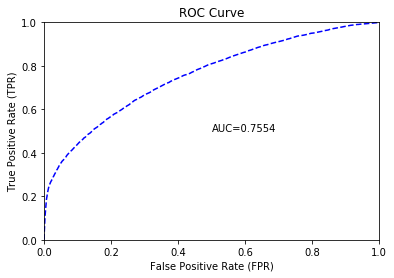

In [35]:
glm_logistic.model_performance(xval=True).plot()

In [36]:
glm_logistic.model_performance(xval = True)


ModelMetricsBinomialGLM: glm
** Reported on cross-validation data. **

MSE: 0.08863855914426673
RMSE: 0.297722285266432
LogLoss: 0.3109461687368151
Null degrees of freedom: 58363
Residual degrees of freedom: 58233
Null deviance: 43710.15000107558
Residual deviance: 36296.12438431095
AIC: 36558.12438431095
AUC: 0.7554103966000639
pr_auc: 0.4298750195080056
Gini: 0.5108207932001279

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20527265397248828: 

,,0,1,Error,Rate
0,0,47608.0,3530.0,0.069,(3530.0/51138.0)
1,1,4406.0,2820.0,0.6097,(4406.0/7226.0)
2,Total,52014.0,6350.0,0.136,(7936.0/58364.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.205273,0.415439,181.0
1,max f2,0.098959,0.492542,281.0
2,max f0point5,0.405622,0.513452,113.0
3,max accuracy,0.511019,0.894455,94.0
4,max precision,0.952842,1.000000,0.0
5,max recall,0.004806,1.000000,399.0
6,max specificity,0.952842,1.000000,0.0
7,max absolute_mcc,0.405622,0.375102,113.0
8,max min_per_class_accuracy,0.106759,0.680433,271.0
9,max mean_per_class_accuracy,0.116406,0.685334,259.0



Gains/Lift Table: Avg response rate: 12.38 %, avg score: 12.38 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010006,0.824079,6.942853,6.942853,0.859589,0.872529,0.859589,0.872529,0.069471,0.069471,594.285286,594.285286
1,,2,0.020012,0.744023,6.196012,6.569432,0.767123,0.784177,0.813356,0.828353,0.061998,0.131470,519.601212,556.943249
2,,3,0.030001,0.645215,5.804871,6.314870,0.718696,0.695235,0.781839,0.784031,0.057985,0.189455,480.487082,531.486970
3,,4,0.040008,0.474296,4.522536,5.866594,0.559932,0.570463,0.726338,0.730616,0.045253,0.234708,352.253563,486.659428
4,,5,0.050014,0.336532,3.015024,5.296085,0.373288,0.392749,0.655704,0.663019,0.030169,0.264877,201.502375,429.608480
5,,6,0.100010,0.213908,2.167323,3.731972,0.268334,0.256539,0.462052,0.459814,0.108359,0.373236,116.732263,273.197173
6,,7,0.150007,0.174965,1.558369,3.007520,0.192940,0.192055,0.372359,0.370571,0.077913,0.451149,55.836864,200.752012
7,,8,0.200003,0.151339,1.276035,2.574686,0.157985,0.162182,0.318770,0.318478,0.063797,0.514946,27.603542,157.468603
8,,9,0.299997,0.120315,1.067053,2.072171,0.132111,0.134683,0.256554,0.257217,0.106698,0.621644,6.705348,107.217055
9,,10,0.400007,0.099858,0.903588,1.780000,0.111873,0.109422,0.220380,0.220265,0.090368,0.712012,-9.641174,77.999995


In [37]:
glm_logistic.coef()

{'Intercept': 11.748957239535708,
 'model_short.1500': 0.0,
 'model_short.2500': 0.0,
 'model_short.300': 0.0,
 'model_short.300M': 0.0,
 'model_short.350Z': 0.0,
 'model_short.4 RUNNER': 0.1535003954435282,
 'model_short.626': 0.0,
 'model_short.ACCENT': 0.0,
 'model_short.ACCORD': 0.0,
 'model_short.AERIO': -0.00012909663336077942,
 'model_short.ALERO': 0.0,
 'model_short.AMANTI': 0.0,
 'model_short.ARMADA': 0.0,
 'model_short.AURA': 0.0,
 'model_short.AVENGER': -0.2201861047348635,
 'model_short.AVEO': 0.7612180995865977,
 'model_short.AVIATOR': 0.27462560191803914,
 'model_short.AXIOM': 0.0,
 'model_short.AZERA': 0.0,
 'model_short.B2300 PICKUP': 0.0,
 'model_short.B3000 PICKUP': 0.0,
 'model_short.BRAVADA': 0.0,
 'model_short.CAMARO': 0.0,
 'model_short.CAMRY': -0.20270095478557199,
 'model_short.CANYON': 0.0,
 'model_short.CARAVAN': -0.3542901957736228,
 'model_short.CAVALIER': 0.09692207085781944,
 'model_short.CENTURY': -0.14954699998230275,
 'model_short.CHARGER': -0.038962025

In [38]:
#Confusion matrix
glm_logistic.confusion_matrix(xval = True)


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20527265397248828: 

,,0,1,Error,Rate
0,0,47608.0,3530.0,0.069,(3530.0/51138.0)
1,1,4406.0,2820.0,0.6097,(4406.0/7226.0)
2,Total,52014.0,6350.0,0.136,(7936.0/58364.0)


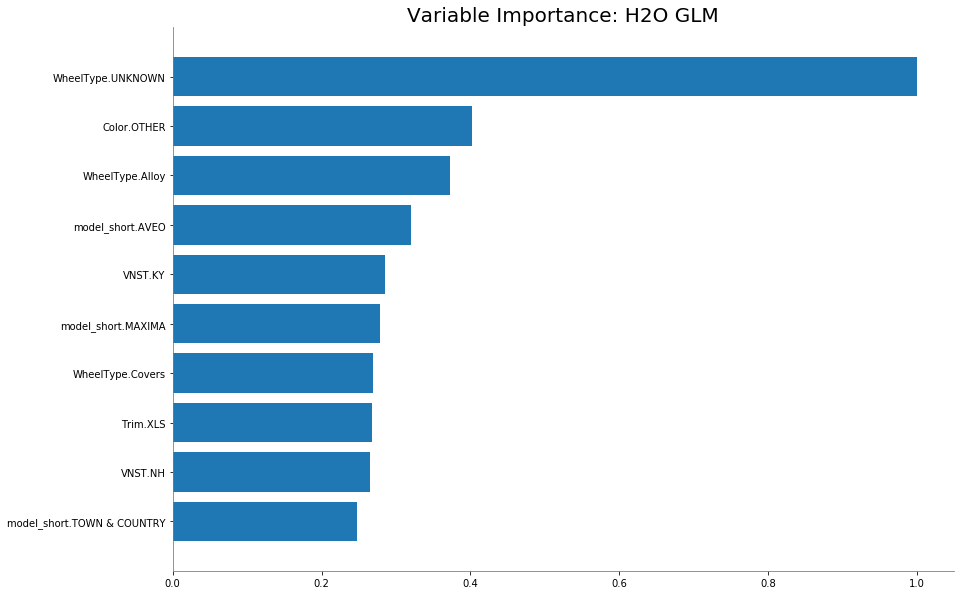

In [39]:
glm_logistic.varimp_plot()

## Support Vector Machine (H2O)

In [40]:
from h2o.estimators.psvm import H2OSupportVectorMachineEstimator
from h2o.grid.grid_search import H2OGridSearch
# SVM hyperparameters
svm_params1 = {'max_iterations': 1000, 'disable_training_metrics': False}

In [41]:
svm_model = H2OSupportVectorMachineEstimator(**svm_params1)

In [42]:
svm_model.train(x=isBad_x, y=isBad_y, training_frame=train, validation_frame=valid)

psvm Model Build progress: |██████████████████████████████████████████████| 100%


In [43]:
print("Summary: " + str(svm_model.summary))
#print("Accuracy: " + str(svm_model.accuracy()))

Model Details
H2OSupportVectorMachineEstimator :  PSVM
Model Key:  PSVM_model_python_1569600840470_304


Model Summary: 

,,number_of_support_vectors,number_of_bounded_support_vectors,raw_model_size_in_bytes,rho,number_of_iterations,surrogate_gap,primal_residual,dual_residual
0,,58342.0,7239.0,10268192.0,-0.813553,15.0,0.000286,1.900844e-10,1.023131e-10




ModelMetricsBinomial: psvm
** Reported on train data. **

MSE: 0.20216229182372694
RMSE: 0.4496246121196291
LogLoss: NaN
Mean Per-Class Error: 0.30639031778433345
AUC: NaN
pr_auc: NaN
Gini: NaN

Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.0: 

,,0,1,Error,Rate
0,0,42554.0,8584.0,0.1679,(8584.0/51138.0)
1,1,3215.0,4011.0,0.4449,(3215.0/7226.0)
2,Total,45769.0,12595.0,0.2022,(11799.0/58364.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,1.0,0.404722,0.0
1,max f2,1.0,0.483265,0.0
2,max f0point5,1.0,0.348141,0.0
3,max accuracy,1.0,0.797838,0.0
4,max precision,1.0,0.318460,0.0
5,max recall,1.0,0.555079,0.0
6,max specificity,1.0,0.832140,0.0
7,max absolute_mcc,1.0,0.310022,0.0
8,max min_per_class_accuracy,1.0,0.555079,0.0
9,max mean_per_class_accuracy,1.0,0.693610,0.0



ModelMetricsBinomial: psvm
** Reported on validation data. **

MSE: 0.25265511458915596
RMSE: 0.5026481021441899
LogLoss: NaN
Mean Per-Class Error: 0.4571768944208423
AUC: NaN
pr_auc: NaN
Gini: NaN

Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.0: 

,,0,1,Error,Rate
0,0,5107.0,1158.0,0.1848,(1158.0/6265.0)
1,1,650.0,241.0,0.7295,(650.0/891.0)
2,Total,5757.0,1399.0,0.2527,(1808.0/7156.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,1.0,0.210480,0.0
1,max f2,1.0,0.242797,0.0
2,max f0point5,1.0,0.185756,0.0
3,max accuracy,1.0,0.747345,0.0
4,max precision,1.0,0.172266,0.0
5,max recall,1.0,0.270483,0.0
6,max specificity,1.0,0.815164,0.0
7,max absolute_mcc,1.0,0.071302,0.0
8,max min_per_class_accuracy,1.0,0.270483,0.0
9,max mean_per_class_accuracy,1.0,0.542823,0.0


Summary: <bound method ModelBase.summary of >


In [44]:
#Confusion matrix
svm_model.confusion_matrix()


Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.0: 

,,0,1,Error,Rate
0,0,42554.0,8584.0,0.1679,(8584.0/51138.0)
1,1,3215.0,4011.0,0.4449,(3215.0/7226.0)
2,Total,45769.0,12595.0,0.2022,(11799.0/58364.0)


In [54]:
#try a gridsearch
#hyper_parameters = {'gamma': [0.001, 0.01, 0.1, 1],
#                   'sv_threshold': [0.0001, 0.001, 0.01, 0.1, 1],
#                   'hyper_param': [0.001, 0.01, 0.1, 1, 10]}

#search_criteria = { 'strategy': "RandomDiscrete", 'seed': 42,
#                    'stopping_metric': "AUTO",
#                    'stopping_tolerance': 0.001,
#                    'stopping_rounds': 2 }

#gridsearch = H2OGridSearch(H2OSupportVectorMachineEstimator(**svm_params1),
#                                   hyper_parameters,
#                                   grid_id='gridsearch',
#                                   search_criteria=search_criteria)

In [56]:
#gridsearch.train(x=isBad_x, y=isBad_y, training_frame=train, validation_frame=valid)

IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Trim,Color,Transmission,WheelTypeID,WheelType,VehOdo,Nationality,Size,TopThreeAmericanName,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionRetailAveragePrice,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost,Mileage,Luxury,Axle,Cylinder,model_short
0,1.26014e+09,ADESA,2006,3,MAZDA,i,RED,AUTO,1,Alloy,0.759487,OTHER ASIAN,MEDIUM,OTHER,0.228291,0.297748,21973,33619,FL,0.156132,0,0.0925242,HIGH,0,Unknown,Unknown,MAZDA3
0,1.26014e+09,ADESA,2004,5,DODGE,ST,WHITE,AUTO,1,Alloy,0.800491,AMERICAN,LARGE TRUCK,CHRYSLER,0.191871,0.278838,19638,33619,FL,0.167129,0,0.0839966,HIGH,0,2WD,Unknown,1500
0,1.26014e+09,ADESA,2005,4,DODGE,SXT,MAROON,AUTO,2,Covers,0.622065,AMERICAN,MEDIUM,CHRYSLER,0.0896366,0.177661,19638,33619,FL,0.107746,0,0.131751,HIGH,0,Unknown,V6,S
0,1.26014e+09,ADESA,2005,4,FORD,ZX3,SILVER,MANUAL,2,Covers,0.582026,AMERICAN,COMPACT,FORD,0.10954,0.19762,19638,33619,FL,0.087952,0,0.0793064,HIGH,0,Unknown,Unknown,S
0,1.26014e+09,ADESA,2004,5,MITSUBISHI,ES,WHITE,AUTO,2,Covers,0.687417,OTHER ASIAN,MEDIUM,OTHER,0.109204,0.171597,19638,33619,FL,0.123142,0,0.0187607,HIGH,0,Unknown,V4,L
0,1.26014e+09,ADESA,2004,5,KIA,EX,BLACK,AUTO,2,Covers,0.545603,OTHER ASIAN,MEDIUM,OTHER,0.0830301,0.159672,19638,33619,FL,0.0923507,0,0.010091,GOOD,0,Unknown,Unknown,S
0,1.26014e+09,ADESA,2005,4,FORD,SE,WHITE,AUTO,2,Covers,0.549904,AMERICAN,MEDIUM,FORD,0.092744,0.170599,19638,33619,FL,0.0989487,0,0.0515918,HIGH,0,Unknown,Unknown,S
0,1.26014e+09,ADESA,2007,2,KIA,EX,BLACK,AUTO,2,Covers,0.406666,OTHER ASIAN,MEDIUM,OTHER,0.173451,0.247876,21973,33619,FL,0.123142,0,0.00284252,HIGH,0,Unknown,Unknown,S
0,1.26075e+09,ADESA,2005,4,GMC,SLE,SILVER,AUTO,1,Alloy,0.678633,AMERICAN,LARGE TRUCK,GM,0.146772,0.226407,5546,33619,FL,0.120942,0,0.129477,HIGH,0,Unknown,Unknown,S
0,1.26075e+09,ADESA,2001,8,FORD,XL,WHITE,MANUAL,1,Alloy,0.636601,AMERICAN,LARGE TRUCK,FORD,0.0886848,0.149079,5546,33619,FL,0.116544,0,0.0578454,LOW,0,2WD,V6,F150
